In [85]:
from util import *

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import pickle

from scipy import stats
from xgboost import XGBRegressor
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, RandomizedSearchCV
from sklearn.decomposition import PCA
from joblib import dump, load

In [2]:
data_log, data_dash = get_data_frames()
result_total, labels = get_data_concated(data_log, data_dash)

In [5]:
columns_to_remove = [col for col in data_log.columns if data_log[col].nunique() == 1]
df_clean = data_log.drop(columns=columns_to_remove)

In [49]:
df_merged_outer = pd.merge(df_grouped, data_dash, on='timestamp', how='outer')

#df_filled = df_merged_outer.fillna(df_merged_outer.mean(numeric_only=True))
df_filled = df_merged_outer.dropna()
labels_x = df_filled['framesDisplayedCalc']
columns_to_remove = list(data_dash.columns)
columns_to_remove.remove('timestamp')
print(columns_to_remove)
df_grouped = df_filled.drop(columns=columns_to_remove)


['inputBitrate', 'demuxBitrate', 'demuxCorrupted', 'demuxDiscontinuity', 'sendBitrate', 'framesDisplayed', 'playedAudioBuffers', 'decodedVideo', 'decodedAudio', 'framesDisplayedAux', 'playedAudioBuffersAux', 'decodedVideoAux', 'decodedAudioAux', 'framesDisplayedCalc', 'playedAudioBuffersCalc', 'decodedVideoCalc', 'decodedAudioCalc']


In [50]:
if result_total.equals(df_grouped):
    print("iguais")
else:
    print("diferentes")

diferentes


In [51]:
if labels.equals(labels_x):
    print("iguais")
else:
    print("diferentes")
toy = df_grouped.shape


diferentes


In [ ]:
conuter = 0
testagem = 0
for timestamp in df_grouped['timestamp']:
    result_row = result_total[result_total['timestamp'] == timestamp]
    df_grouped_row = df_grouped[df_grouped['timestamp'] == timestamp]

    if not result_row.empty and not df_grouped_row.empty:
        testagem+=1
        for column in df_grouped.columns:
            if column != 'timestamp':  
                result_value = result_row.iloc[0][column]
                grouped_value = df_grouped_row.iloc[0][column]
                
                if result_value != grouped_value:
                    conuter += 1
                    print(f"Diferença na coluna '{column}' para timestamp {timestamp}: "
                          f"{result_value} != {grouped_value} {testagem/toy[0]*100:.4f}% completo")

print(f"Total de diferenças detectadas: {conuter}")


MAE para esta divisão: 8.13008266275351
NMAE para esta divisão: 0.37945633805644535
MAE para esta divisão: 8.47010404049391
NMAE para esta divisão: 0.39833566785625246
MAE para esta divisão: 9.586998520397009
NMAE para esta divisão: 0.4221175533498548
MAE para esta divisão: 8.228339740514823
NMAE para esta divisão: 0.41101391386968145
MAE para esta divisão: 7.011789392191623
NMAE para esta divisão: 0.35612346879030626
Mean Absolute Error médio em todas as divisões: 8.285462871270173


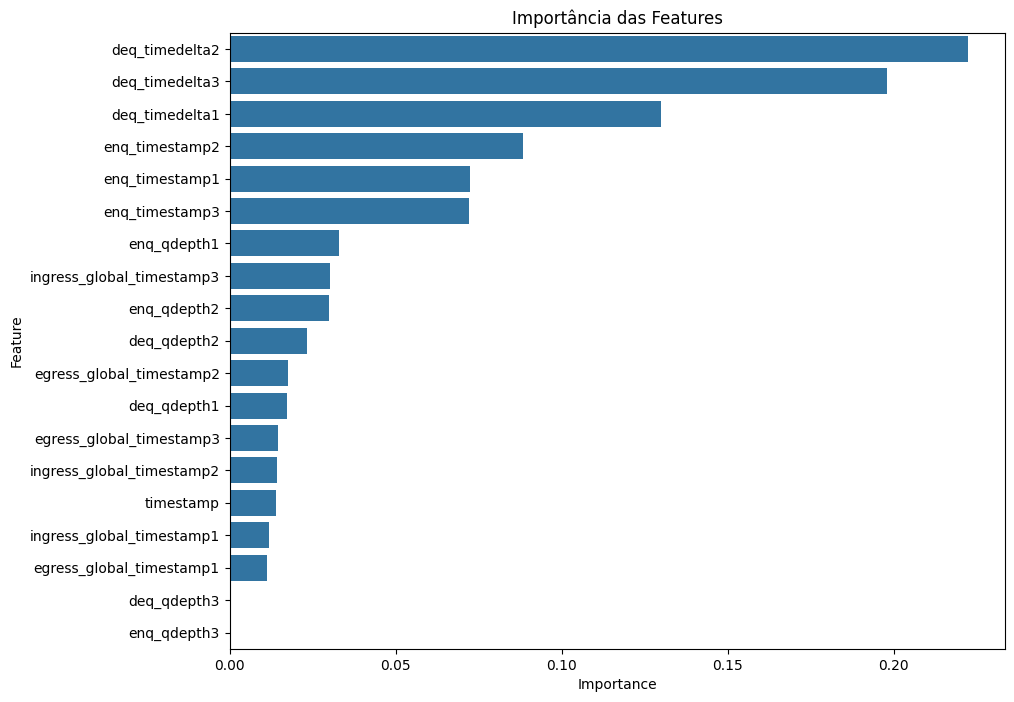

In [53]:
X = features
Y = labels

imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
X_imputed = X_imputed.drop(columns=['timestamp'])
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor(
        n_estimators=120, 
        max_depth=40, 
        min_samples_split=2, 
        min_samples_leaf=1, 
        random_state=42,
        n_jobs=2
    ))
])

kf = KFold(n_splits=5, shuffle=True, random_state=42)
mae_scores = []

for train_index, test_index in kf.split(X_imputed):
    X_train, X_eval = X_imputed.iloc[train_index], X_imputed.iloc[test_index]
    Y_train, Y_eval = Y.iloc[train_index], Y.iloc[test_index]
    
    pipeline.fit(X_train, Y_train)
    
    Y_pred = pipeline.predict(X_eval)
    
    mae = mean_absolute_error(Y_eval, Y_pred)
    nmae = mae / Y_eval.mean() 
    mae_scores.append(mae)
    
    print(f'MAE para esta divisão: {mae}')
    print(f'NMAE para esta divisão: {nmae}')

mean_mae = np.mean(mae_scores)
print(f'Mean Absolute Error médio em todas as divisões: {mean_mae}')

pipeline.fit(X_imputed, Y)

importances = pipeline.named_steps['regressor'].feature_importances_
feature_names = X_imputed.columns
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importances_df)
plt.title('Importância das Features')
plt.show()


In [95]:
data_log, data_dash = get_data_frames()

data_log_grouped = data_log.groupby("timestamp", as_index=False).mean()


features = pd.concat(
    [data_log_grouped.set_index("timestamp"), data_dash.set_index("timestamp")],
    axis=1,
    join="outer",
)

features = features.reset_index()
imputer = KNNImputer(n_neighbors=5)

#features = pd.DataFrame(imputer.fit_transform(features), columns=features.columns)
#features = features.fillna(features.mean(numeric_only=True))
features = features.dropna()
z_scores = np.abs(stats.zscore(features['framesDisplayedCalc']))
threshold = 3
features = features[(z_scores < threshold)]
labels = features["framesDisplayedCalc"]


columns_to_remove = list(data_dash.columns) + [
    col for col in data_log.columns if data_log[col].nunique() == 1
]
columns_to_remove.remove("timestamp")

features = features.drop(columns=columns_to_remove)


In [77]:
def nmae(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    nmae_value = mae / np.mean(y_true)
    return nmae_value
def train_rf_model_gridsearch(features_train: pd.DataFrame, labels_train: pd.Series):
    X_train, X_validation, y_train, y_validation = train_test_split(
        features_train,
        np.ravel(labels_train),
        test_size=0.20,
        random_state=42
    )
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_validation_scaled = scaler.transform(X_validation)

    rf_model = RandomForestRegressor(random_state=42, n_jobs=2)

    nmae_scorer = make_scorer(nmae, greater_is_better=False)

    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    n_estimators = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]
    max_features = ['auto', 'sqrt']
    max_depth = [int(x) for x in np.linspace(start=10, stop=100, num=11)]
    max_depth.append(None)
    min_samples_split = [2, 5, 10]
    min_samples_leaf = [1, 2, 4]
    bootstrap = [True, False]

    random_grid = {
        'n_estimators': [50, 100, 200],
        'max_features': ['sqrt', 'log2'],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    }

    grid_search = GridSearchCV(
        estimator=rf_model,
        param_grid=random_grid,
        scoring=nmae_scorer,
        cv=kf,
        verbose=3,  
        n_jobs=2
    )
    random_search = RandomizedSearchCV(
        estimator=rf_model,
        param_distributions=random_grid,
        scoring=nmae_scorer,
        n_iter=100,  
        cv=kf,
        verbose=3,
        random_state=42,
        n_jobs=2
    )

    random_search.fit(X_train_scaled, y_train)

    best_rf_model = random_search.best_estimator_
    best_params = random_search.best_params_

    print(f"Melhores hiperparâmetros: {best_params}")

    y_pred_rf = best_rf_model.predict(X_validation_scaled)
    mae_rf = mean_absolute_error(y_validation, y_pred_rf)
    nmae_rf = nmae(y_validation, y_pred_rf)

    feature_importances = best_rf_model.feature_importances_
    print(f"Importâncias das features: {feature_importances}")

    return mae_rf, nmae_rf, best_rf_model, feature_importances


In [96]:
mae_rf, nmae_rf, best_rf_model, feature_importances = train_rf_model_gridsearch(features, labels)
alert_end()

Fitting 5 folds for each of 6480 candidates, totalling 32400 fits


[CV 1/5] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=nan total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=nan total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=nan total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=nan total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=nan total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=20;, score=nan total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=

KeyboardInterrupt: 

In [89]:
features

,timestamp,ingress_global_timestamp3,egress_global_timestamp3,enq_timestamp3,enq_qdepth3,deq_timedelta3,deq_qdepth3,ingress_global_timestamp2,egress_global_timestamp2,enq_timestamp2,enq_qdepth2,deq_timedelta2,deq_qdepth2,ingress_global_timestamp1,egress_global_timestamp1,enq_timestamp1,enq_qdepth1,deq_timedelta1,deq_qdepth1
0,1.621899e+09,3.909507e+10,3.909507e+10,4.403598e+08,0.0,34.000000,0.0,3.916932e+10,3.916932e+10,5.146125e+08,0.000000,34.000000,0.000000,3.924525e+10,3.924525e+10,5.905407e+08,0.000000,32.400000,0.000000
1,1.621899e+09,3.909580e+10,3.909580e+10,4.410972e+08,0.0,26.333333,0.0,3.917006e+10,3.917006e+10,5.153497e+08,0.000000,36.500000,0.000000,3.924598e+10,3.924598e+10,5.912778e+08,0.000000,30.333333,0.000000
2,1.621899e+09,3.909691e+10,3.909691e+10,4.422026e+08,0.0,27.166667,0.0,3.917116e+10,3.917116e+10,5.164553e+08,0.000000,26.000000,0.000000,3.924709e+10,3.924709e+10,5.923834e+08,0.000000,31.166667,0.000000
3,1.621899e+09,3.909790e+10,3.909790e+10,4.431917e+08,0.0,28.142857,0.0,3.917215e+10,3.917215e+10,5.174444e+08,0.000000,31.428571,0.000000,3.924808e+10,3.924808e+10,5.933725e+08,0.000000,28.285714,0.000000
4,1.621899e+09,3.909885e+10,3.909885e+10,4.441475e+08,0.0,41.888889,0.0,3.917311e+10,3.917311e+10,5.184002e+08,0.000000,31.777778,0.000000,3.924903e+10,3.924903e+10,5.943283e+08,0.000000,32.666667,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32247,1.621927e+09,6.800028e+10,6.800028e+10,2.716775e+09,0.0,148.587970,0.0,6.807473e+10,6.807473e+10,2.791224e+09,1.467481,186.253634,0.750063,6.815045e+10,6.815045e+10,2.866950e+09,0.707237,216.331736,1.142105
32248,1.621932e+09,7.050487e+10,7.050487e+10,1.785395e+09,0.0,99.165680,0.0,7.057917e+10,7.057917e+10,1.859697e+09,0.347059,102.926084,0.339338,7.065506e+10,7.065506e+10,1.935579e+09,1.506860,239.570414,1.114458
32249,1.621932e+09,6.992009e+10,6.992009e+10,2.059612e+09,0.0,94.097510,0.0,6.999443e+10,6.999443e+10,2.133948e+09,0.323333,71.794712,0.163325,7.007027e+10,7.007027e+10,1.350796e+09,1.813200,271.639891,1.208772
32250,1.621932e+09,7.114270e+10,7.114270e+10,2.423219e+09,0.0,137.976680,0.0,7.121695e+10,7.121695e+10,2.497470e+09,0.392941,167.064683,0.195588,7.129287e+10,7.129287e+10,2.573394e+09,1.796749,363.006076,1.686842


In [ ]:
def get_data_frames():
    # telemetry data
    data_log = pd.read_csv("datasets/log_INT_sinusoid_8h.txt", delimiter=",")
    data_log.columns = data_log.columns.str.replace(" ", "")
    # QoS data
    data_dash = pd.read_csv("datasets/dash_sinusoid_8h.log", sep=",")
    return data_log, data_dash
    
def get_data_concated(data_log, data_dash):
    # Remover colunas constante
    for colum in data_log.columns:
        if(data_log[colum].std() == 0.0):
            data_log = data_log.drop(columns=[colum])

    # Agrupar por 'timestamp' e calcular a média
    data_log = data_log.groupby("timestamp").mean().reset_index()

    # Concatenar os dataframes
    result_total = pd.concat(
        [data_log.set_index("timestamp"), data_dash.set_index("timestamp")],
        axis=1,
        join="outer"
    )
    # Preencher valores nulos com a média de cada coluna
    result_total = result_total.fillna(result_total.mean())

    # Remover outliers com base no Z-score
    z_scores = np.abs(stats.zscore(result_total['framesDisplayedCalc']))
    threshold = 3
    result_total = result_total[(z_scores < threshold)]

    # Extrair os labels
    labels = result_total['framesDisplayedCalc']

    # Remover colunas do data_dash
    columns_to_remove = list(data_dash.columns)
    columns_to_remove.remove('timestamp')
    result_total = result_total.drop(columns=columns_to_remove)
    
    return result_total, labels